We're all familiar with the daily struggle of trying to find the closed form integral of some function $f(x)$ -- can't seem to find the time, right? Or perhaps, more likely, the required mathematics is simply rather grueling. Well, it turns out that we typically just need to *approximate* the definite integral, that is, to find the (net) *area under the curve* between some fixed limits, $[a, b]$:

\begin{align} \int_{a}^{b} f(x) \, dx \end{align}

Enter **numerical integration**. Instead of computing eq. (1) analytically, we can simply pass the mathematical burden over to our beloved computers and use geometry to estimate the true integral. In this post, we will explore three widely adopted (yet relatively simple) algorithms for numerical integration, using the following problem as a case study:

\begin{align} \int_{0}^{\frac{3\pi}{2}} \texttt{sin}(x) + 1 \, dx = 1 + \frac{3}{2} \pi \approx 5.712 \end{align}

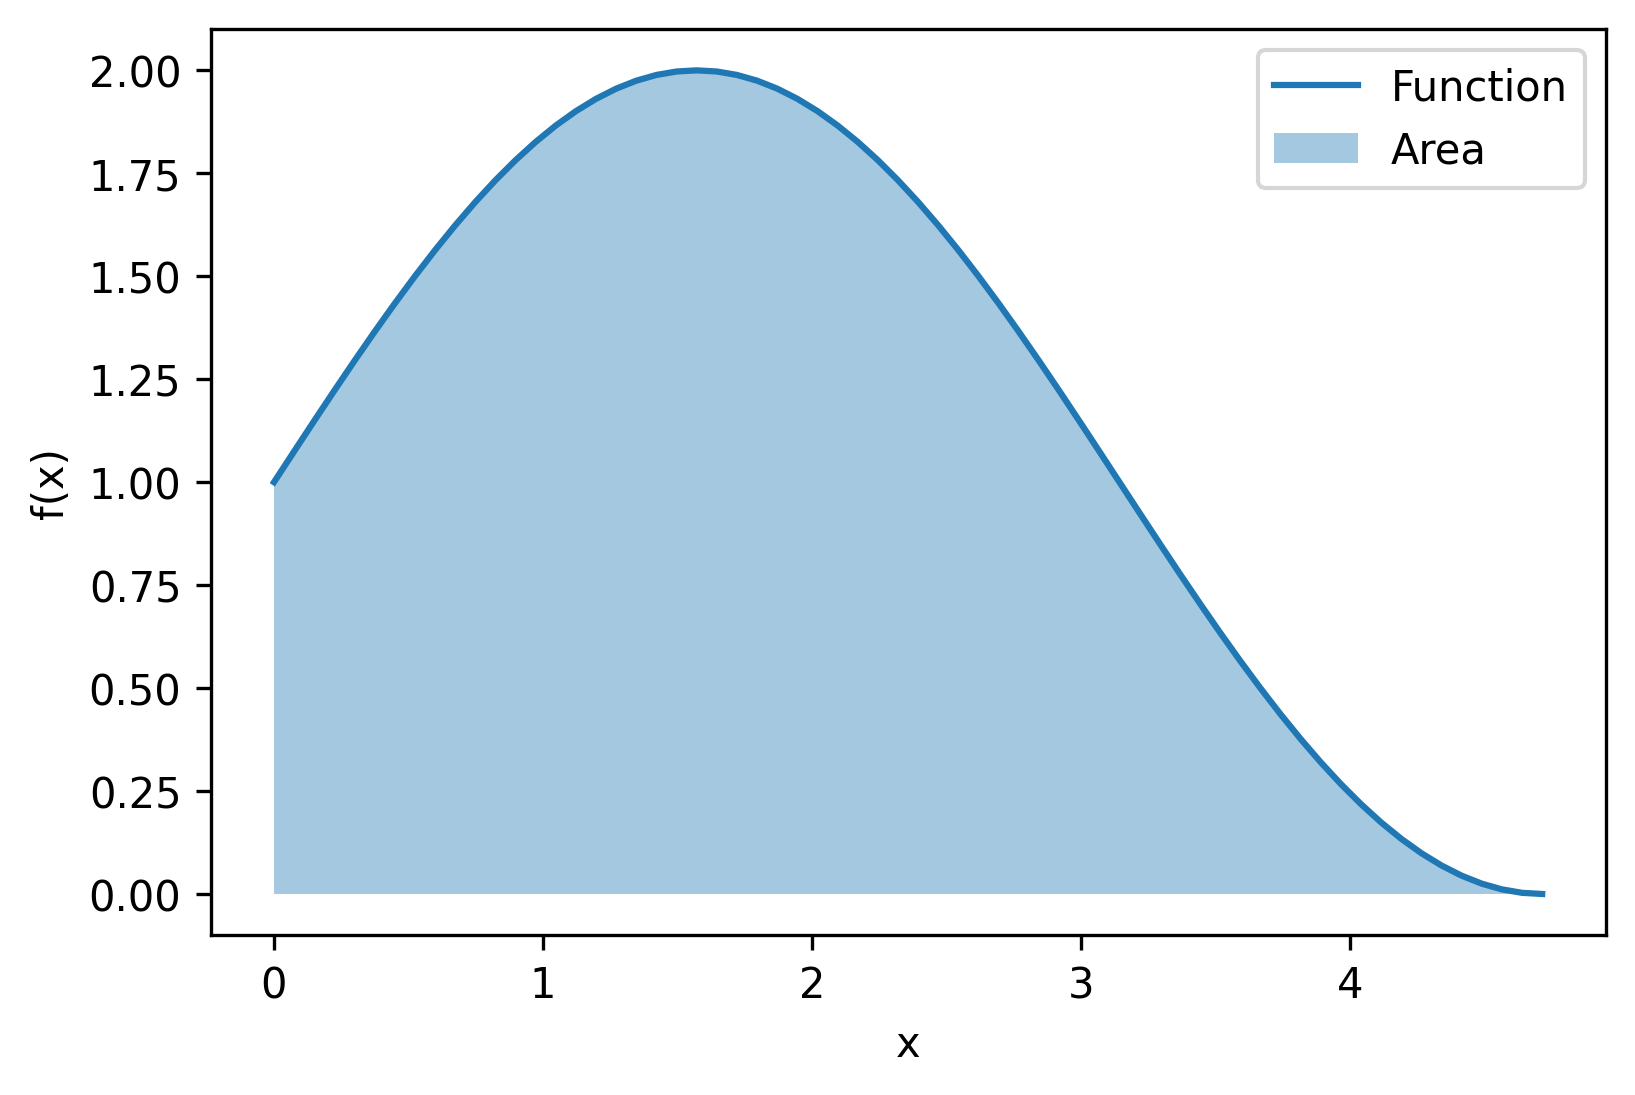

In [49]:
import numpy as np
import matplotlib.pyplot as plt

def fn(x):
    return np.sin(x) + 1

def percentage_error(area): # Used later evaluate the utility of each approximation
    return 100 * abs((area / (1 + (3 / 2) * np.pi) - 1))

n = 4
a, b = 0, 3 / 2 * np.pi
xs = np.linspace(a, b, n ** 3)

plt.figure(dpi=300); plt.plot(xs, fn(xs), label="Function")
plt.fill_between(xs, 0, fn(xs), alpha=0.4, label="Area")
plt.xlabel("x"), plt.ylabel("f(x)"), plt.legend();

### Reimann Sum

Arguably the most simple algorithms for numerical approximation of definite integrals is the Reimann sum (a.k.a rectange rule), which (like all of the methods discussed in this tutorial) is based on the intuition that we can partition the interval $[a, b]$ into $n$ subintervals such that:

\begin{align} a = x_0 < \dots < x_n = b \end{align}

In [50]:
xs_sub = np.linspace(a, b, n + 1)

Here, $\Delta x = \frac{1}{n}(b-a)$ is the common length of each subinterval such that $x_i = a + i\Delta{x}$

In [51]:
dx = (b - a) / n

Each interval (of equal width) is used to construct a rectangle, the height of which is determined by $f(x)$. We can then simply evaluate a piecewise constant approximation of the integral by summing up their respective areas:

\begin{align} \int_{a}^{b} f(x) \, dx \approx \sum_{i=1}^n f(\tilde{x_i})(x_i - x_{i-1}) \end{align}

In [52]:
def reimann(fn, xs, dx):
    return sum(fn(xs) * dx)

Note, although the value $\tilde{x_i} \in [x_{i-1}, x_i]$ is arbitary, we typically adopt one of three policies with respect to the subinterval. 

\begin{align} \tilde{x_i} = \begin{cases} x_{i-1} &\textrm{ : Left rule} \\\ x_{i} &\textrm{ : Right rule} \\\ \frac{1}{2}(x_{i-1} + x_{i}) &\textrm{ : Midpoint rule} \end{cases} \end{align}

The first policy is the **left rule**, where $\tilde{x_i}$ takes on the value of the subinterval lower bounds:

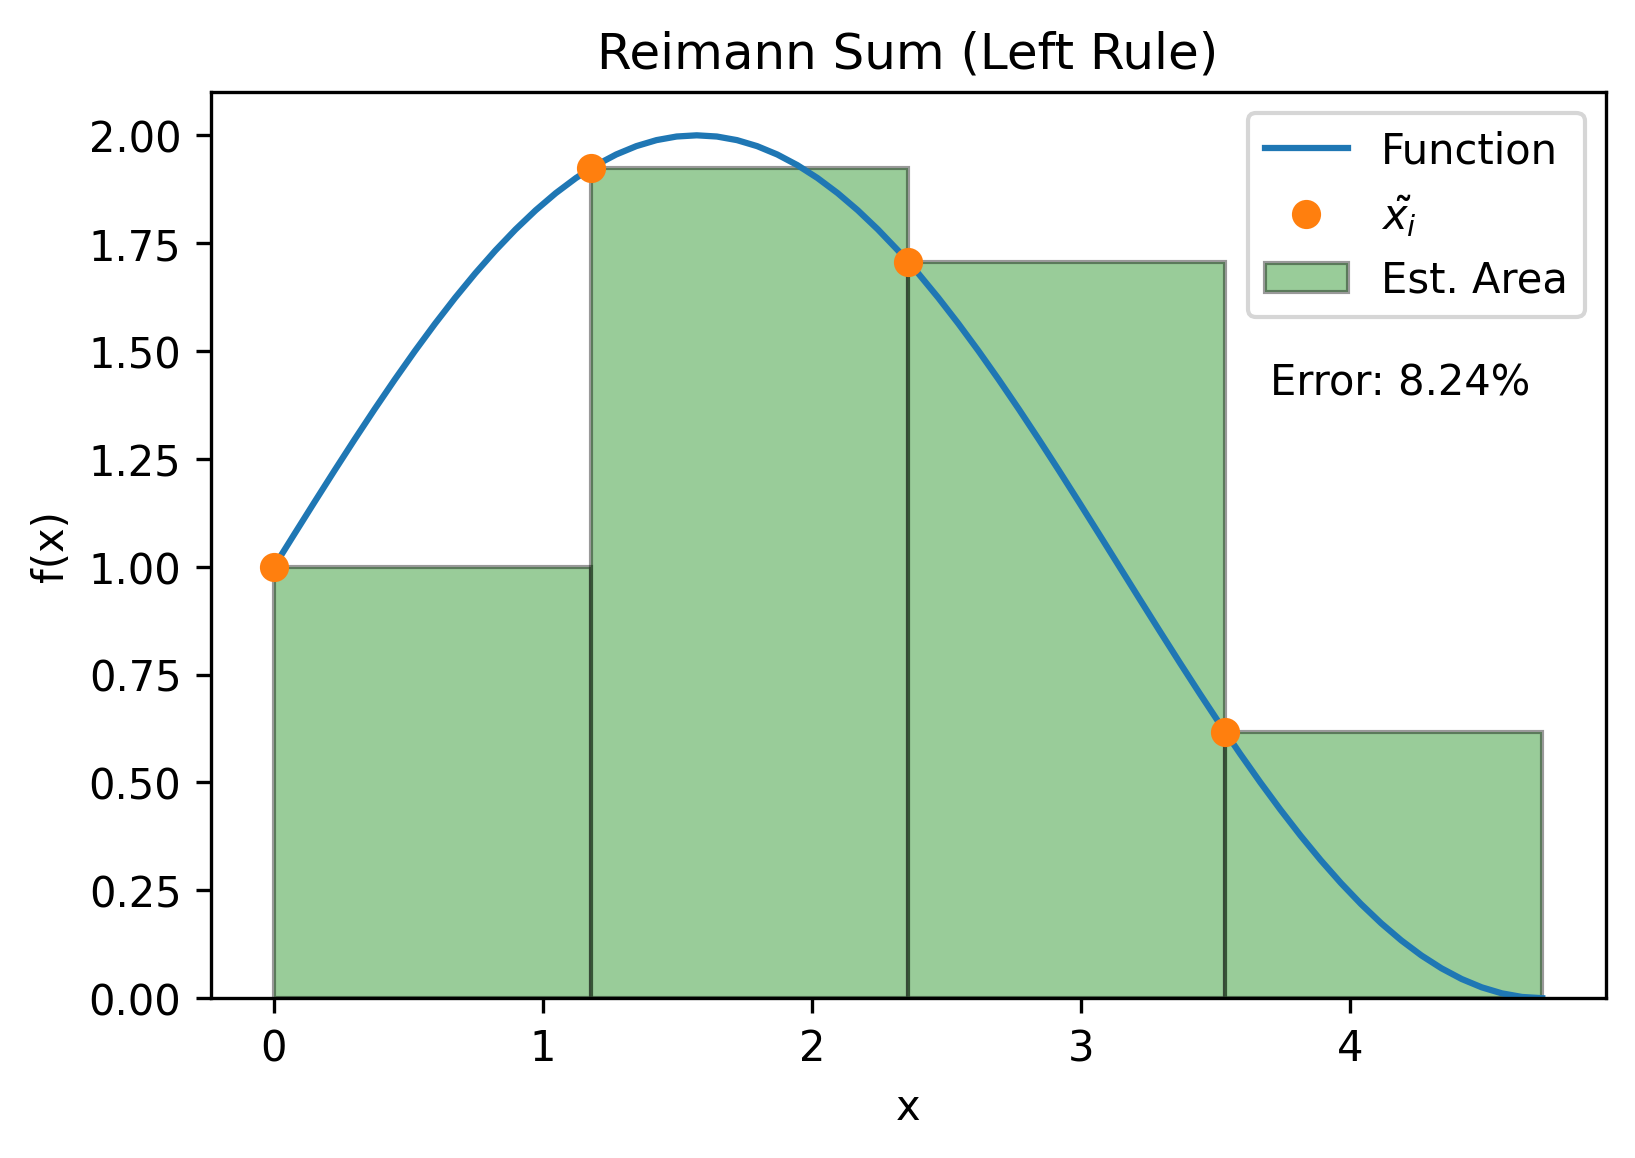

In [61]:
def plot_reimann_rule(xs, sub, fn, dx, approximation, title, align="edge"):
    kwargs = dict(edgecolor="k", color="green", alpha=0.4)
    plt.figure(dpi=300); plt.plot(xs, fn(xs), label="Function")
    plt.plot(sub, fn(sub), "o", label="$\\tilde{x_i}$")    
    plt.bar(sub, fn(sub), width=dx, align=align, label="Est. Area", **kwargs)
    plt.annotate(f"Error: {percentage_error(approximation):.2f}%", (3.7, 1.4))
    plt.xlabel("x"); plt.ylabel("f(x)"); plt.title(title); plt.legend()
    
xs_left = xs_sub[:-1]
approximation = reimann(fn, xs_left, dx)
plot_reimann_rule(xs, xs_left, fn, dx, approximation, "Reimann Sum (Left Rule)")

The second policy is the **right rule**, where $\tilde{x_i}$ takes on the value of the subinterval upper bounds:

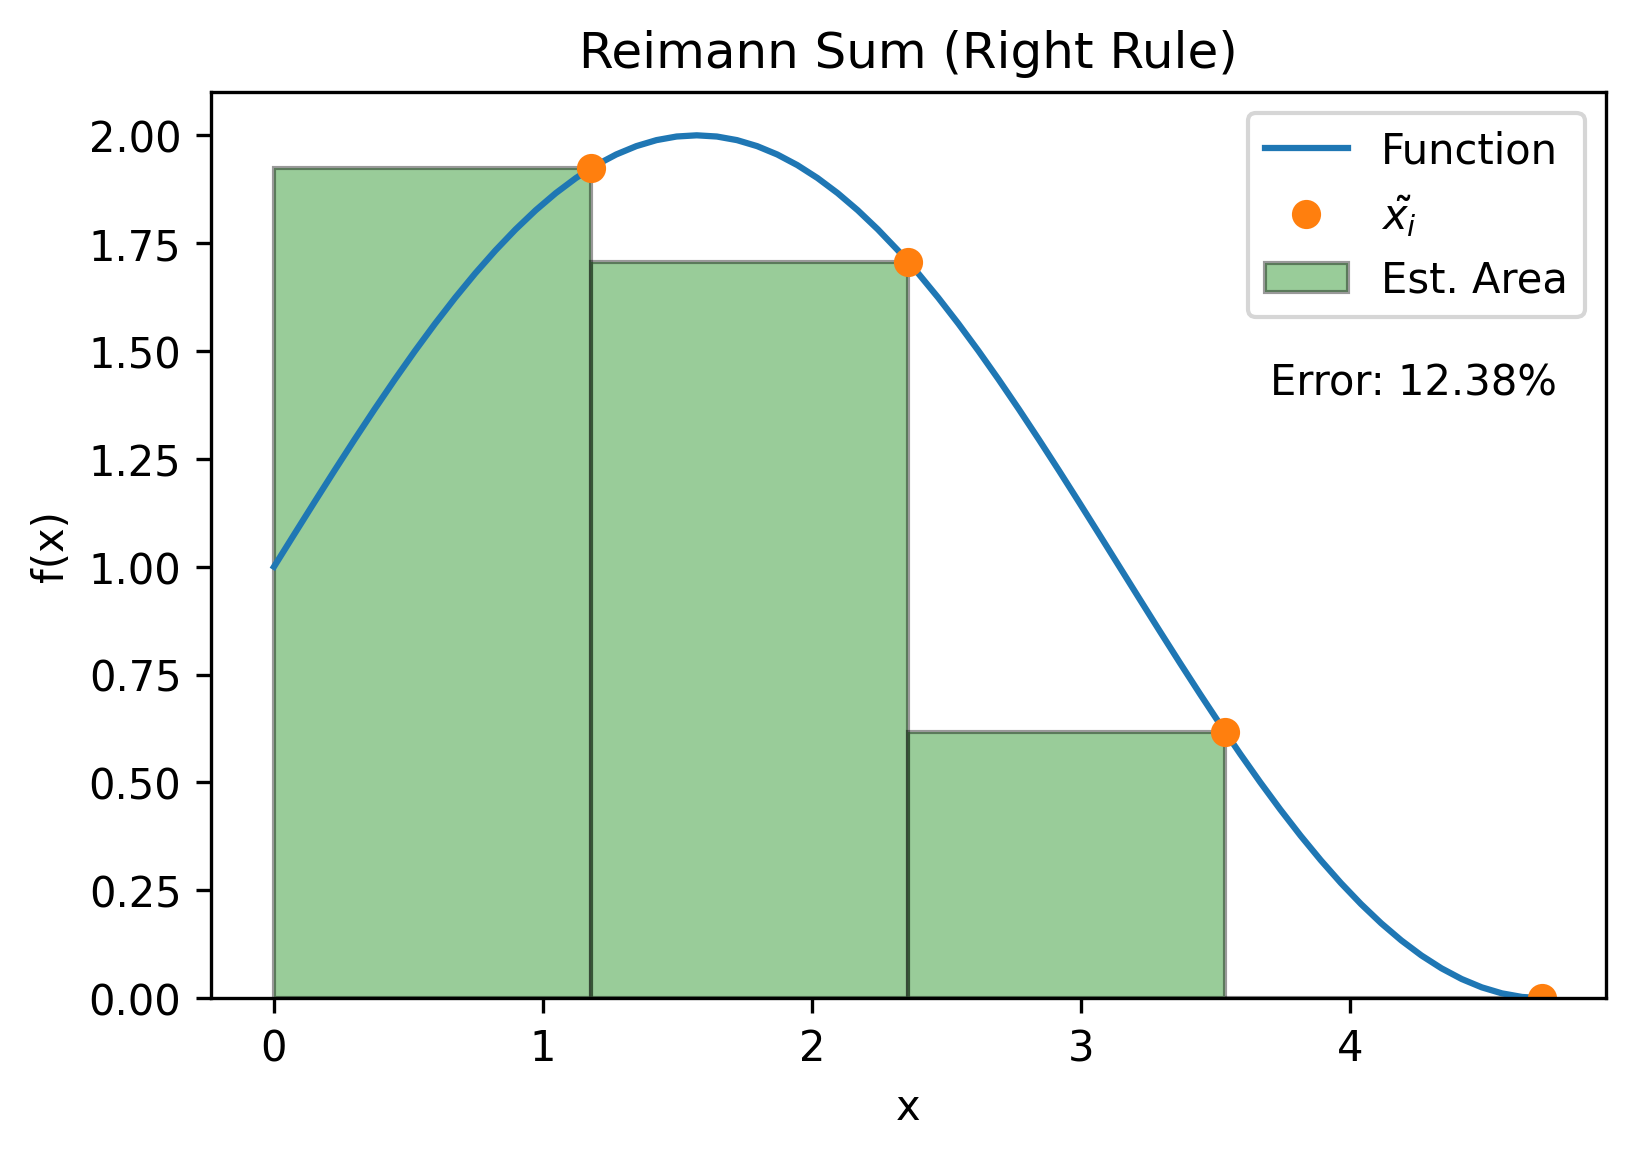

In [62]:
xs_right = xs_sub[1:]
approximation = reimann(fn, xs_right, dx)
plot_reimann_rule(xs, xs_right, fn, -dx, approximation, "Reimann Sum (Right Rule)")

The last policy is the **midpoint rule**, where $\tilde{x_i}$ takes on the value of the subinterval medians:

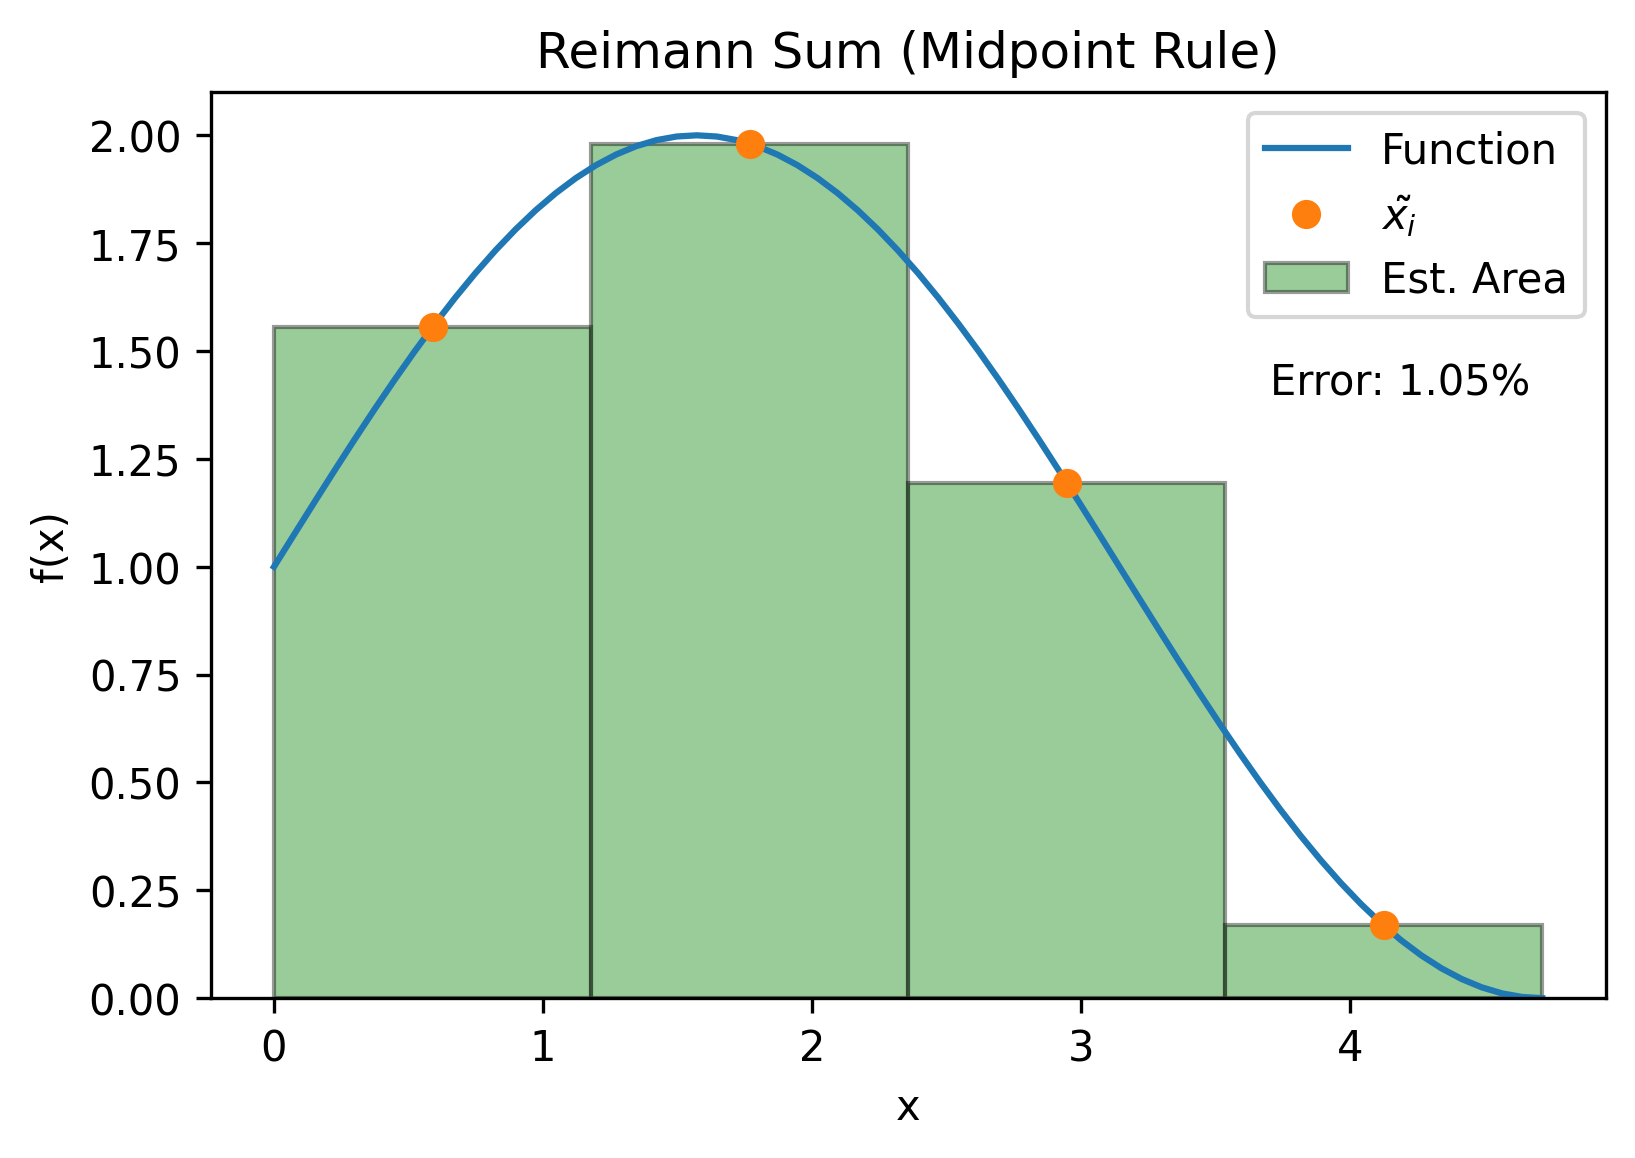

In [55]:
xs_mid = (xs_sub[:-1] + xs_sub[1:]) / 2
approximation = reimann(fn, xs_mid, dx)
plot_reimann_rule(xs, xs_mid, fn, -dx, approximation, "Reimann Sum (Midpoint Rule)", align="center")

Notice that when $f(x)$ is decreasing, the left (right) rule overestimates (underestimates) the integral. The inverse is true when the function is increasing. Without going into the math, it can be [proven](https://en.wikipedia.org/wiki/Riemann_sum) that both the left and right rules in fact share the same error bound, that is, as $n \rightarrow \infty$, the error is inversely proportional to $n$. The midpoint rule however is inversely proporotional to $n^2$, hence this method scales better with $n$.

### Trapezoidal Rule

Another common (and typically more accurate) algorithm for numerical integration is the trapezoidal rule, which constructs trapezoids (instead of rectangles) between the lower and upper bounds of each subinterval. We therefore formulate a piecewise linear approximate of the integral by summing up the areas of each trapezoid:

\begin{align} \int_{a}^{b} f(x) \approx \frac{\Delta x}{2} \sum_{i=1}^n(f(x_i) + f(x_{i-1})) = \frac{1}{2} \left( \sum_{i=1}^nf(x_i) \Delta x  + \sum_{i=1}^nf(x_{i-1}) \Delta x  \right) \end{align}

In [56]:
def trapz(fn, xs, dx):
    ys = fn(xs)
    return (dx / 2) * np.sum(ys[1:] + ys[:-1])

It can be [proven](https://en.wikipedia.org/wiki/Trapezoidal_rule) that as $n \rightarrow \infty$, the error is inversely proportional to $n^2$. However, whilst increasing the number of points provides a better approximation, the computation time will subsequently increase, and so we have a tradeoff between accuracy and computational efficiency.

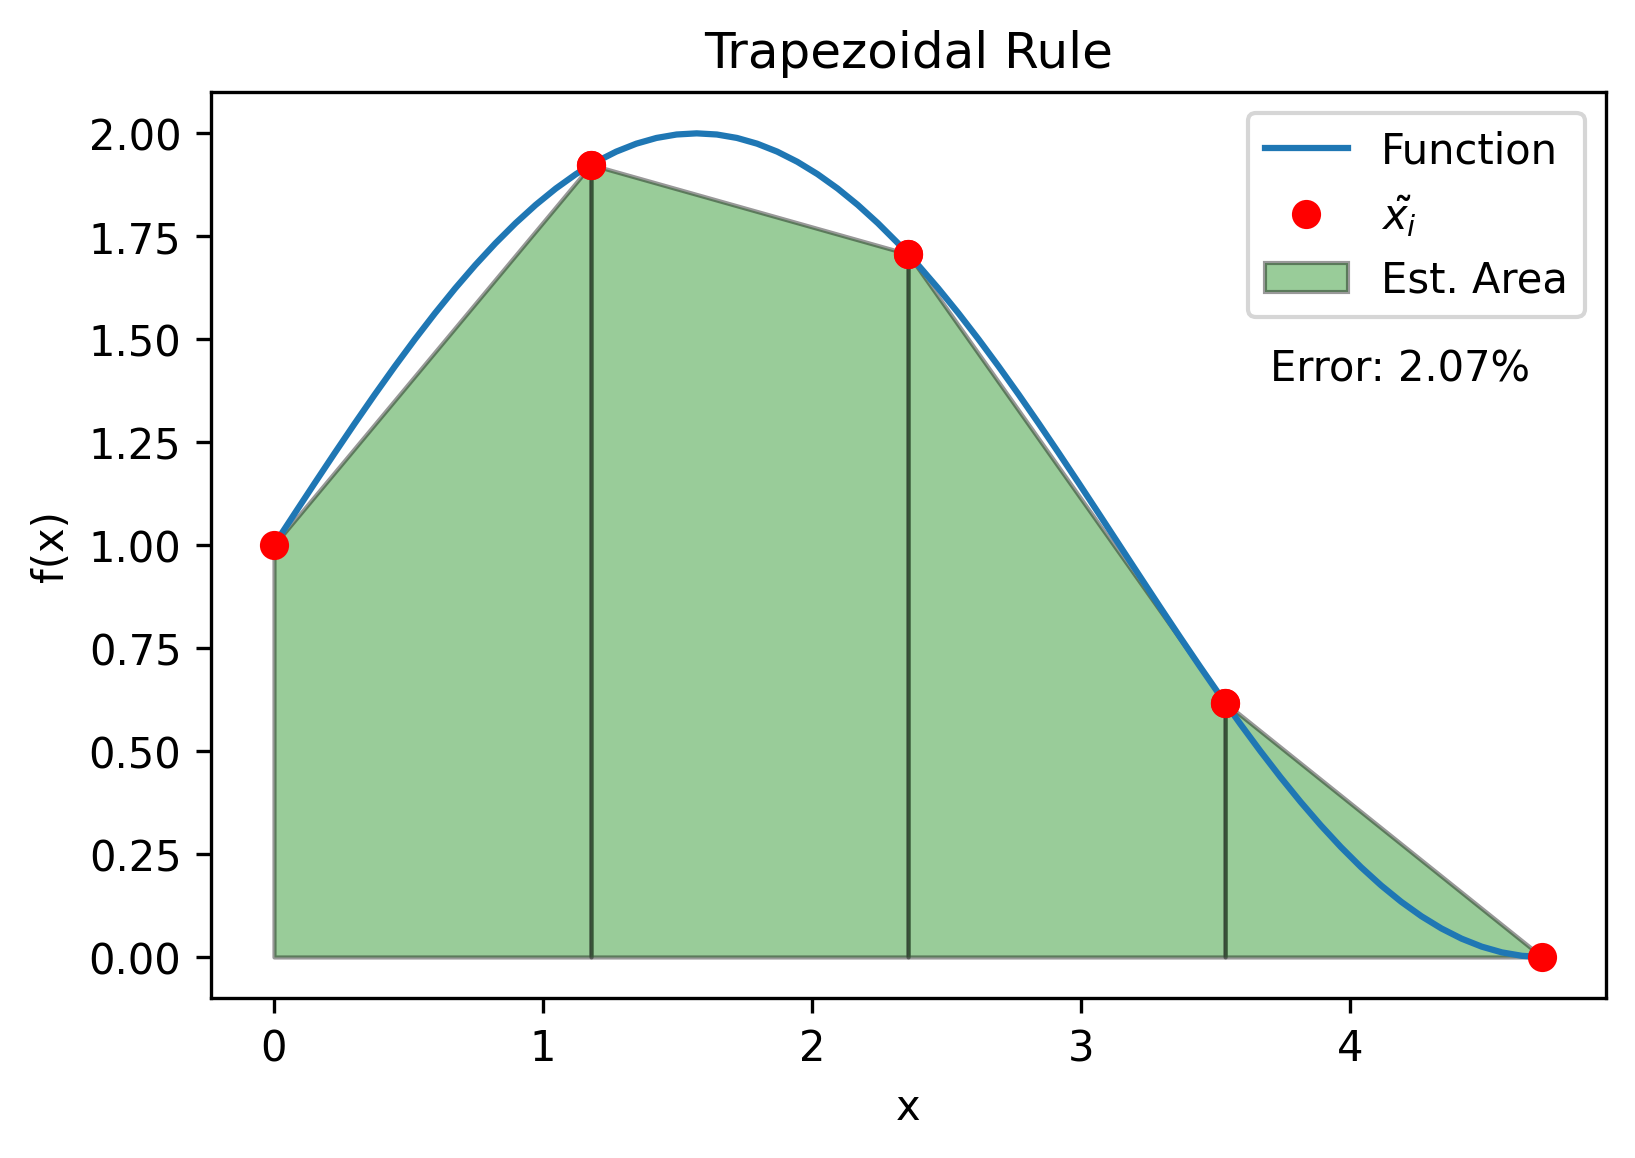

In [57]:
approximation = trapz(fn, xs_sub, dx)
plt.figure(dpi=300); plt.plot(xs, fn(xs), label="Function")
for i in range(n):  
    kwargs = dict(edgecolor="k", facecolor="green", alpha=0.4)
    xs_trap = np.array([xs_sub[i], xs_sub[i+1]])
    plt.plot(xs_trap, fn(xs_trap), "o", c="red", label="$\\tilde{x_i}$" if i == 0 else None)
    plt.fill_between(xs_trap, fn(xs_trap), 0, label="Est. Area" if i == 0 else None, **kwargs)
plt.annotate(f"Error: {percentage_error(approximation):.2f}%", (3.7, 1.4))
plt.xlabel("x"); plt.ylabel("f(x)"); plt.title("Trapezoidal Rule"); plt.legend();

It should be noted that for intervals where the function is convex (concave), the Trapezoidal rule tends to overestimate (underestimate) the definite integral, whereas the midpoint rule Reimann Sum would, by both partially over- and under-estimating the value, average out such errors. Therefore in some cases (as observed above), the midpoint rule Reimann Sum tends to be more accurate than the Trapezoidal rule. 

### Simpson's Rule
Last but by no means least, we have Simpson's rule. Instead of using linear approximations, Simpson's rule levereages the fact that we can uniqely define a parabola with three points, thereby providing a piecewise quadratic approximation of the definite integral four our function using the following formula (a detailed derivation can be found [here](https://en.wikipedia.org/wiki/Simpson%27s_rule)):

\begin{align} \int_{a}^{b} f(x) \approx \frac{\Delta x}{3} \sum_{i=1}^{\frac{N}{2}} (f(x_{2i-2}) + 4f(x_{2i-1}) + f(x_{2i}) \end{align}





In [58]:
def simps(fn, xs, dx):
    ys = fn(xs)
    return dx / 3 * np.sum(ys[0:-1:2] + 4 * ys[1::2] + ys[2::2])

Note that since we need three function values to define the quadratic approximation, which is an odd number, Simpson's rule requires an even number of subintervals. 

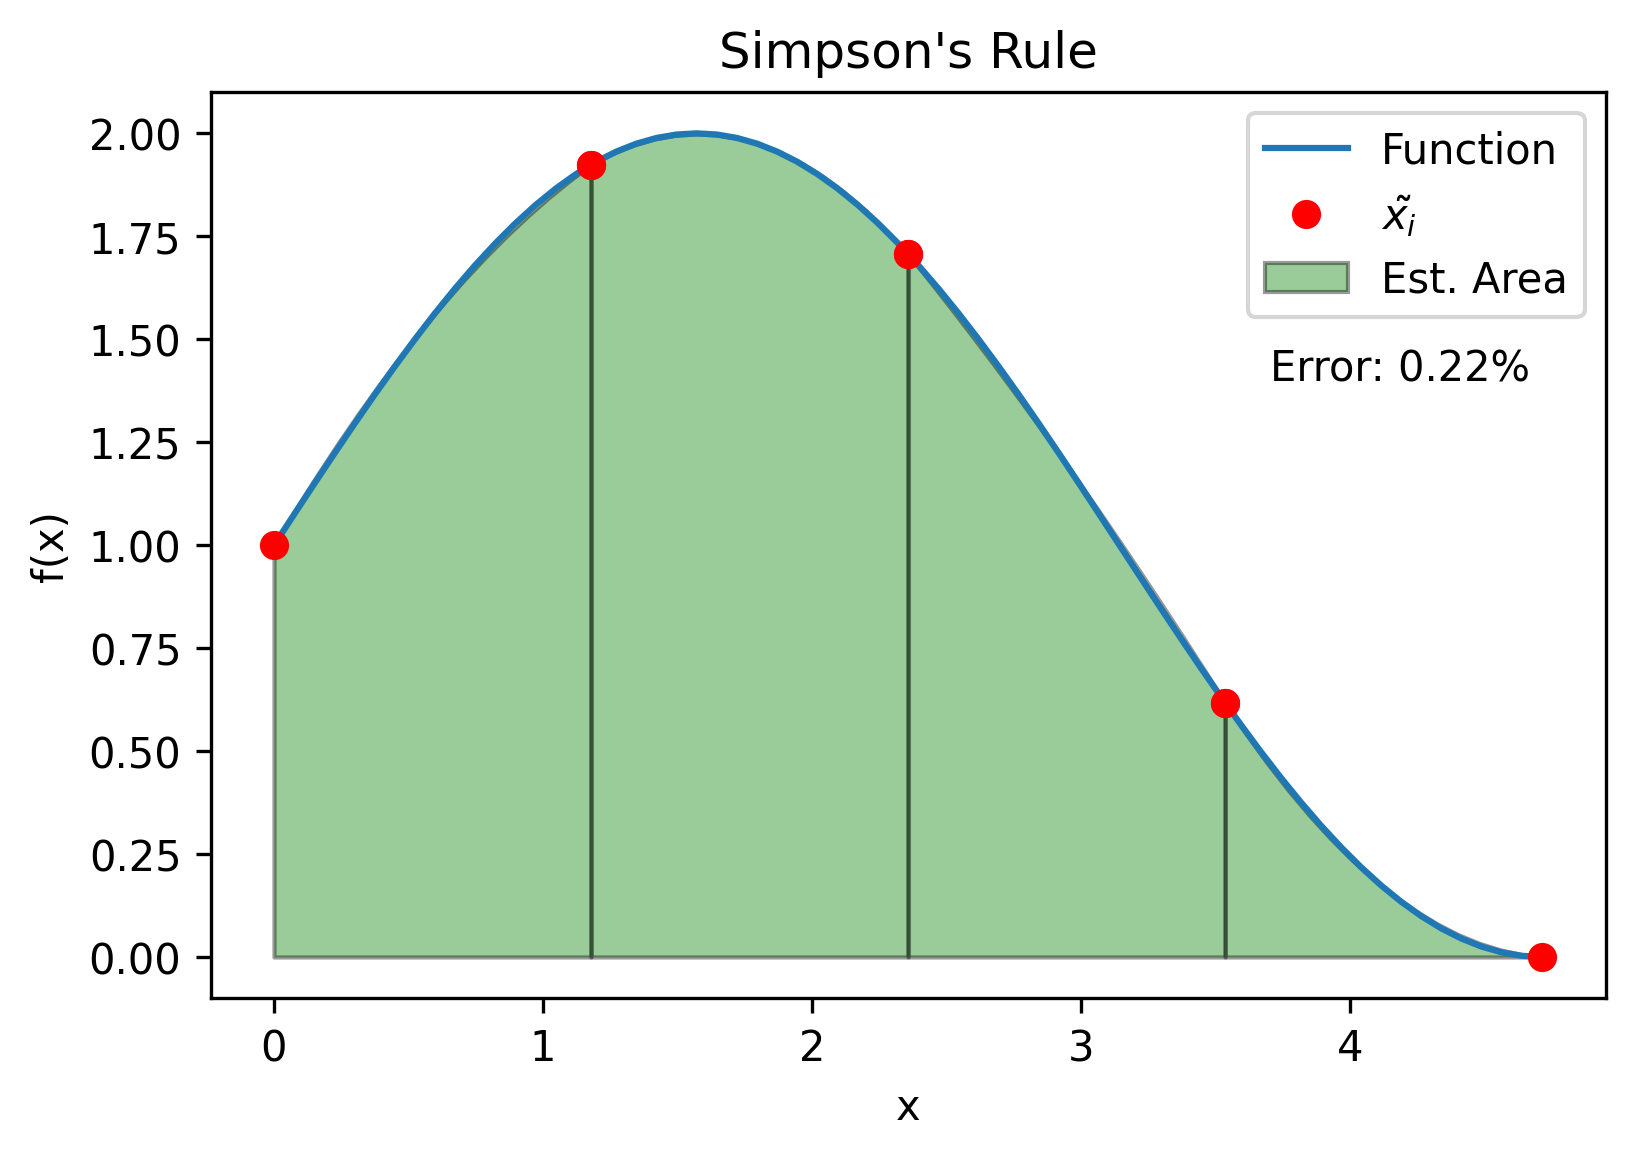

In [63]:
from scipy.interpolate import interp1d

approximation = simps(fn, xs_sub, dx)
plt.figure(dpi=300); plt.plot(xs, fn(xs), label="Function")
for i in range(n):
    kwargs = dict(edgecolor="k", facecolor="green", alpha=0.4)
    xs_simps = np.array([xs_sub[i], (xs_sub[i] + xs_sub[i + 1]) / 2, xs_sub[i + 1]])
    plt.plot(xs_simps[::2], fn(xs_simps[::2]), "o", c="red", label="$\\tilde{x_i}$" if i == 0 else None)
    xs_quad = np.linspace(xs_simps[0], xs_simps[-1], n ** 2)
    quadratic = interp1d(xs_simps, fn(xs_simps), kind='quadratic')
    plt.fill_between(xs_quad, quadratic(xs_quad), label="Est. Area" if i == 0 else None, **kwargs)
plt.annotate(f"Error: {percentage_error(approximation):.2f}%", (3.7, 1.4))
plt.xlabel("x"); plt.ylabel("f(x)"); plt.title("Simpson's Rule"); plt.legend();

We have seen that the approximation error of both the left rule and right rule Riemann sums, and both the midpoint rule Riemann sum and the Trapezoidal rule, are inversely proportional to $n$ and $n^2$, respectively. Simpson's rule has a far superior error bound, that is, as $n \rightarrow \infty$ the error is inversely proportional to $n^4$.

### Final Note
Before we finish, it should be noted that whilst we have implemented these approximation methods ourselves, the `SciPy` subpackage `scipy.integrate`contains many built-in functions for numerical integration that we can use to avoid re-inventing the wheel (details can be found [here](https://docs.scipy.org/doc/scipy/tutorial/integrate.html)) .

I hope that you enjoyed this brief introduction to numerical integration and that you will be able to leverage these methods to make your life easier on a daily basis ;o).